In [15]:
import numpy as np
import pandas as pd
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
import cv2
from common import *
from models import *
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import pickle
from matplotlib import cm as matplot_cm

print(tf. __version__) 
# print('tensorflow version', tf.__version__)
# print(tf.config.list_physical_devices('GPU'))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(f"Root directory: {os.getcwd()}")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

#%matplotlib

2.3.0
Root directory: c:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project2\FYS-STK4155-Prj2_report\code


In [16]:



# filename = f"best_model.pkl"
# save_model(model, filename)
# load_model(filename)

# Global variables

In [17]:
SEED_VALUE = 70707070
np.random.seed(SEED_VALUE)
SAVE_FIGURES = False

# Reading data and resizing

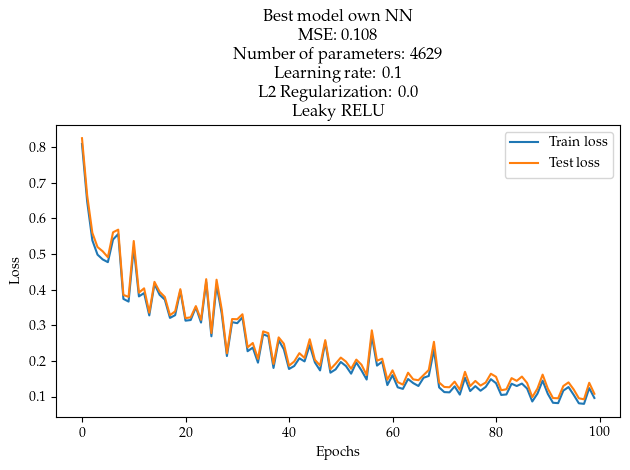

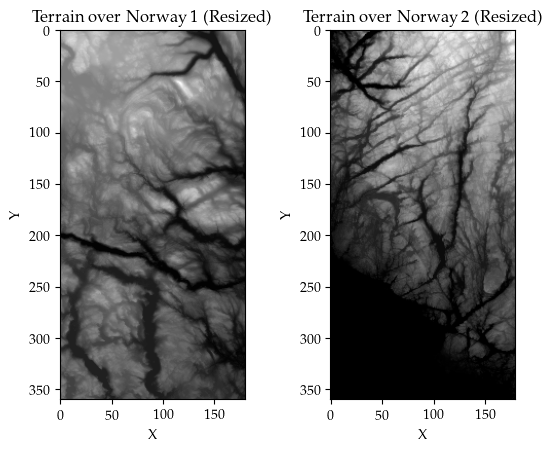

In [18]:
# Load the terrain
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 =  imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

# Resizing the image
rescale_factor = 0.1
y_size = int(terrain1.shape[0] * rescale_factor)
x_size = int(terrain1.shape[1] * rescale_factor)
terrain1Resized = cv2.resize(terrain1, (x_size, y_size))
terrain2Resized = cv2.resize(terrain2, (x_size, y_size))

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1 (Resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text("Terrain over Norway 2 (Resized)")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2Resized, cmap='gray')

if SAVE_FIGURES:
    plt.savefig(f"{REPORT_FIGURES}{EX_A}terrain_data_resized.pdf")
plt.show()

# Creating image patches and Terrain data selection

In [30]:
nXpatches = 3; nYpatches=6
y_steps = int(terrain2Resized.shape[0] / nYpatches); print(y_steps)
x_steps = int(terrain2Resized.shape[1] / nXpatches); print(x_steps)

patches_1 = create_img_patches(terrain1Resized, y_steps, x_steps)
if SAVE_FIGURES:
    fig1 = plotTerrainPatches(patches_1, nYpatches, nXpatches, plotTitle="Terrain1 patches")
    plt.savefig(f"{REPORT_FIGURES}{EX_A}Terrain1_patches.pdf")
    plt.show()

patches_2 = create_img_patches(terrain2Resized, y_steps, x_steps)
if SAVE_FIGURES:
    fig2 = plotTerrainPatches(patches_2, nYpatches, nXpatches, plotTitle="Terrain2 patches")
    plt.savefig(f"{REPORT_FIGURES}{EX_A}Terrain2_patches.pdf")
    plt.show()

# Choosing two interesting terrain patches
img1 = patches_1[2]
img2 = patches_2[5]
x1, y1, z1 = createTerrainData(img1)
x2, y2, z2 = createTerrainData(img2)

# Constructing the terrain data
terrain_data = 1
if terrain_data == 1: # Choosing terrain1*
    x, y, z = x1, y1, z1.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z1

elif terrain_data == 2: # Choosing terrain2
    x, y, z = x2, y2, z2.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z2
    
z_flat = z.ravel(); z_flat = z_flat.reshape(-1,1)

60
60


# ploting of best model and its prediction result

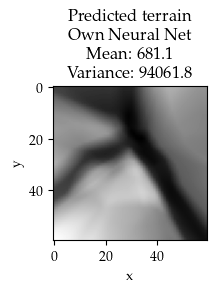

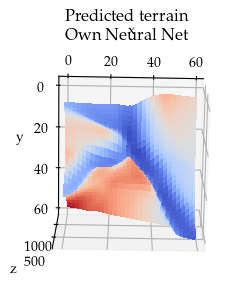

In [20]:
path= "../data/models/the_very_best_model/"
filename = f"{path}best_large_model_leaky_relu_mse_0.108.pkl"
best_model = load_model(filename)

deg = 1
X = create_X(x, y, deg) # Design Matrix 
X = remove_intercept(X)
X_scaled, _ = standard_scaling_single(X)
z_scaled, z_scaler = standard_scaling_single(z.ravel().reshape(-1,1))


z_hat = best_model.predict(X_scaled)
z_hat = z_scaler.inverse_transform(z_hat.reshape(-1,1))
z_hat = z_hat.reshape((y_steps,x_steps))
mean_val = np.round(np.mean(z_hat),decimals=1)
var_val = np.round(np.var(z_hat),decimals=1)

# 2D plot of predicted terrain 
plt.figure(figsize=(2,2))
plt.imshow(z_hat ,cmap='gray')
title = f"Predicted terrain\nOwn Neural Net\nMean: {mean_val}\nVariance: {var_val}"
plt.title(title)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(f"{path}2d_plot.pdf")
plt.show()


# 3D plot of predicted terrain
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
title = f"Predicted terrain\nOwn Neural Net"
ax.title.set_text(title)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
#ax2.view_init(elev=60., azim=-120.0-70)
ax.view_init(elev=-75., azim=-91)
sutf = ax.plot_surface(x, y, z_hat, cmap=matplot_cm.coolwarm, linewidth = 0, antialiased=False)
plt.savefig(f"{path}3d_plot.pdf")
plt.show()

# Real Terrain data

In [31]:
np.random.seed(4155)

degree = 1
X = create_X(x,y, degree)
X = X[:,1:]

X_train, X_test, t_train, t_test = train_test_split(X, z_flat, test_size=0.2, shuffle=True)

X_train, X_test = standard_scaling(X_train, X_test)
t_train, t_test = standard_scaling(t_train, t_test)

lr_upper_limit = learning_rate_upper_limit(X_train)

Upper limit learing rate: 0.9900859685598116


# Grid search common parameters

In [32]:
epochs = 100
batch_size = 300
nbf_features = X_train.shape[1]
apply_lr_scheduler = False
hidden_sizes = np.array([32,16,8])
eta_list = np.logspace(-1, -4, 6)
lmb_list = np.concatenate([np.zeros(1).astype(float), np.logspace(-5, -3, 5)], axis=0)

# Grid search  - RELU

In [33]:
act_func = "relu"

### Simple architecture

In [35]:
heatmap_mtrx_MSE = np.zeros(shape=(hidden_sizes.shape[0], eta_list.shape[0], lmb_list.shape[0]))
heatmap_mtrx_MSE_tf = np.zeros_like(heatmap_mtrx_MSE)

parameters_best_MSE = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf ,"parameters":0,
                      "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
parameters_best_MSE_tf = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf , "parameters":0,
                          "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
best_models = {"own_NN":None, "tf_NN":None}

results_simple_df = pd.DataFrame(columns=["MSE_tensorflow","R2_tensorflow","MSE_own_NN","R2_own_NN",
                                          "parameters_own_NN","neurons_first_hidden","learning_rate",
                                          "regularization"])
# Grid search on eta and lambda 
i = 0
for n, hidden_size in tqdm(enumerate(hidden_sizes)):
    for y, lmb in enumerate(lmb_list):
        for x, eta in enumerate(eta_list):
            np.random.seed(4155)
            own_model, tf_model = NN_simple_architecture(eta, nbf_features,
                                                         problem_type="regression",
                                                         X_test=X_test.copy(), t_test=t_test.copy(),
                                                         lmb=lmb, 
                                                         hidden_size=hidden_size, 
                                                         act_func=act_func)
            
            print(f"Neurons in first hidden: {hidden_size} - Parameters: {own_model.nbf_parameters} - Lambda: {lmb} -Eta: {eta}")
            # Own model
            train_losses, test_losses = own_model.fit(X_train.copy(), t_train.copy(), 
                                                            batch_size=batch_size, epochs=epochs,
                                                            lr_scheduler=apply_lr_scheduler, verbose=False)
            t_hat_test_own = own_model.predict(X_test.copy())
            
            MSE_val = np.around(MSE(t_test, t_hat_test_own), decimals=4)
            R2_val = np.around(R2(t_test, t_hat_test_own), decimals=4)
            heatmap_mtrx_MSE[n,y,x] = MSE_val

            if parameters_best_MSE["best_MSE"] > MSE_val:
                print(f"**New best MSE own NN**: {MSE_val}")
                best_models["own_NN"] = own_model
                parameters_best_MSE["best_MSE"] = MSE_val
                parameters_best_MSE["R2_at_best_MSE"] = R2_val
                parameters_best_MSE["parameters"] = own_model.nbf_parameters
                parameters_best_MSE["neurons_first_hidden"] = hidden_size
                parameters_best_MSE["learning_rate"] = eta
                parameters_best_MSE["lambda"] = lmb
                df = pd.DataFrame().from_dict(parameters_best_MSE, orient='index')
                df.to_csv(f"{REPORT_DATA}{EX_C}own_NN_best_training_small_{act_func}.csv")
                
                plt.figure()
                plt.plot(np.arange(epochs), train_losses, label="Train loss")
                plt.plot(np.arange(epochs), test_losses, label="Test loss")
                plt.title(f"Best model own NN\nMSE: {MSE_val}\nNumber of parameters: {own_model.nbf_parameters}\nLearning rate: {eta}\nL2 Regularization: {lmb}\n{act_func}")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"{REPORT_FIGURES}{EX_C}own_NN_best_training_small_{act_func}_lr_{eta}.pdf")
            
                filename = f"../data/models/best_small_model_{act_func}_mse_{np.around(MSE_val, decimals=4)}.pkl"
                save_model(own_model, filename)
                        
            # Tensorflow
            tf_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=0)
            t_hat_test_tf = tf_model.predict(X_test.copy())
            
            MSE_val_tf = np.around(MSE(t_test, t_hat_test_tf), decimals=4)
            heatmap_mtrx_MSE_tf[n, y,x] = MSE_val_tf

            if parameters_best_MSE_tf["best_MSE"] > MSE_val_tf:
                print(f"New best MSE tensorflow: {MSE_val_tf}")
                parameters_best_MSE_tf["best_MSE"] = MSE_val_tf
                parameters_best_MSE_tf["parameters"] = own_model.nbf_parameters
                parameters_best_MSE_tf["neurons_first_hidden"] = hidden_size
                parameters_best_MSE_tf["learning_rate"] = eta
                parameters_best_MSE_tf["lambda"] = lmb
                best_models["tf_NN"] = tf_model
            
            R2_val_tf = np.around(R2(t_test, t_hat_test_tf), decimals=4)
            
            
            results_simple_df.loc[i] = [MSE_val_tf, R2_val_tf, MSE_val, R2_val, 
                                        own_model.nbf_parameters, hidden_size, eta, lmb]
            results_simple_df.to_csv(f"{REPORT_DATA}{EX_C}results_small_{act_func}.csv")
            i+=1
            
    plot_save_NN_results(parameters=own_model.nbf_parameters, model_size="small", eta_list=eta_list, lmb_list=lmb_list, 
                         heatmap_mtrx=heatmap_mtrx_MSE[n, :,:], heatmap_mtrx_tf=heatmap_mtrx_MSE_tf[n, :,:],
                         path=f"{REPORT_FIGURES}{EX_C}", activation_type=act_func)

0it [00:00, ?it/s]

Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.1
**New best MSE own NN**: 1.0212
New best MSE tensorflow: 0.3091
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.1
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in firs

1it [01:11, 71.07s/it]

Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.1
New best MSE tensorflow: 0.302
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.1
New best MSE tensorflow: 0.2964
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 16

2it [02:06, 62.14s/it]

Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.1
**New best MSE own NN**: 0.6824
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.1
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.0

3it [03:37, 72.64s/it]


### Large architecture

In [34]:
heatmap_mtrx_MSE = np.zeros(shape=(hidden_sizes.shape[0], eta_list.shape[0], lmb_list.shape[0]))
heatmap_mtrx_MSE_tf = np.zeros_like(heatmap_mtrx_MSE)

parameters_best_MSE = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf ,"parameters":0,
                      "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
parameters_best_MSE_tf = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf , "parameters":0,
                          "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
best_models = {"own_NN":None, "tf_NN":None}

results_large_df = pd.DataFrame(columns=["MSE_tensorflow","R2_tensorflow","MSE_own_NN","R2_own_NN",
                                          "parameters_own_NN","neurons_first_hidden","learning_rate",
                                          "regularization"])
# Grid search on eta and lambda 
i = 0
for n, hidden_size in tqdm(enumerate(hidden_sizes)):
    for y, lmb in enumerate(lmb_list):
        for x, eta in enumerate(eta_list):
            np.random.seed(4155)
            own_model, tf_model = NN_large_architecture(eta, nbf_features,
                                                         problem_type="regression",
                                                         X_test=X_test.copy(), t_test=t_test.copy(),
                                                         lmb=lmb, 
                                                         hidden_size=hidden_size, 
                                                         act_func=act_func)
            
            print(f"Neurons in first hidden: {hidden_size} - Parameters: {own_model.nbf_parameters} - Lambda: {lmb} -Eta: {eta}")
            # Own model
            train_losses, test_losses = own_model.fit(X_train.copy(), t_train.copy(), 
                                                            batch_size=batch_size, epochs=epochs,
                                                            lr_scheduler=apply_lr_scheduler, verbose=False)
            t_hat_test_own = own_model.predict(X_test.copy())
            
            MSE_val = np.around(MSE(t_test, t_hat_test_own), decimals=4)
            R2_val = np.around(R2(t_test, t_hat_test_own), decimals=4)
            heatmap_mtrx_MSE[n,y,x] = MSE_val

            if parameters_best_MSE["best_MSE"] > MSE_val:
                print(f"**New best MSE own NN**: {MSE_val}")
                best_models["own_NN"] = own_model
                parameters_best_MSE["best_MSE"] = MSE_val
                parameters_best_MSE["R2_at_best_MSE"] = R2_val
                parameters_best_MSE["parameters"] = own_model.nbf_parameters
                parameters_best_MSE["neurons_first_hidden"] = hidden_size
                parameters_best_MSE["learning_rate"] = eta
                parameters_best_MSE["lambda"] = lmb
                df = pd.DataFrame().from_dict(parameters_best_MSE, orient='index')
                df.to_csv(f"{REPORT_DATA}{EX_C}own_NN_best_training_large_{act_func}.csv")
                
                plt.figure()
                plt.plot(np.arange(epochs), train_losses, label="Train loss")
                plt.plot(np.arange(epochs), test_losses, label="Test loss")
                plt.title(f"Best model own NN\nMSE: {MSE_val}\nNumber of parameters: {own_model.nbf_parameters}\nLearning rate: {eta}\nL2 Regularization: {lmb}\n{act_func}")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"{REPORT_FIGURES}{EX_C}own_NN_best_training_large_{act_func}_lr_{eta}.pdf")

                filename = f"../data/models/best_large_model_{act_func}_mse_{np.around(MSE_val, decimals=4)}.pkl"
                save_model(own_model, filename)
                        
            # Tensorflow
            tf_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=0)
            t_hat_test_tf = tf_model.predict(X_test.copy())
            
            MSE_val_tf = np.around(MSE(t_test, t_hat_test_tf), decimals=4)
            heatmap_mtrx_MSE_tf[n, y,x] = MSE_val_tf

            if parameters_best_MSE_tf["best_MSE"] > MSE_val_tf:
                print(f"New best MSE tensorflow: {MSE_val_tf}")
                parameters_best_MSE_tf["best_MSE"] = MSE_val_tf
                parameters_best_MSE_tf["parameters"] = own_model.nbf_parameters
                parameters_best_MSE_tf["neurons_first_hidden"] = hidden_size
                parameters_best_MSE_tf["learning_rate"] = eta
                parameters_best_MSE_tf["lambda"] = lmb
                best_models["tf_NN"] = tf_model
            
            R2_val_tf = np.around(R2(t_test, t_hat_test_tf), decimals=4)
            
            
            results_large_df.loc[i] = [MSE_val_tf, R2_val_tf, MSE_val, R2_val, 
                                        own_model.nbf_parameters, hidden_size, eta, lmb]
            results_large_df.to_csv(f"{REPORT_DATA}{EX_C}results_large_{act_func}.csv")
            i+=1
            
    plot_save_NN_results(parameters=own_model.nbf_parameters, model_size="large", eta_list=eta_list, lmb_list=lmb_list, 
                         heatmap_mtrx=heatmap_mtrx_MSE[n, :,:], heatmap_mtrx_tf=heatmap_mtrx_MSE_tf[n, :,:],
                         path=f"{REPORT_FIGURES}{EX_C}", activation_type=act_func)

0it [00:00, ?it/s]

Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.1
**New best MSE own NN**: 0.154
New best MSE tensorflow: 0.1023
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.1
**New best MSE own NN**: 0.1478
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -E

c:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project2\FYS-STK4155-Prj2_report\code\models.py:490: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 10))
1it [04:31, 271.15s/it]

Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.1
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.1
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta:

2it [07:50, 229.06s/it]

Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.1
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.1
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.0001
Neurons in first

3it [10:01, 200.63s/it]


# Grid search  - Leaky RELU

In [25]:
act_func = "leaky_relu"

### Simple architecture

In [26]:
heatmap_mtrx_MSE = np.zeros(shape=(hidden_sizes.shape[0], eta_list.shape[0], lmb_list.shape[0]))
heatmap_mtrx_MSE_tf = np.zeros_like(heatmap_mtrx_MSE)

parameters_best_MSE = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf ,"parameters":0,
                      "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
parameters_best_MSE_tf = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf , "parameters":0,
                          "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
best_models = {"own_NN":None, "tf_NN":None}

results_simple_df = pd.DataFrame(columns=["MSE_tensorflow","R2_tensorflow","MSE_own_NN","R2_own_NN",
                                          "parameters_own_NN","neurons_first_hidden","learning_rate",
                                          "regularization"])
# Grid search on eta and lambda 
i = 0
for n, hidden_size in tqdm(enumerate(hidden_sizes)):
    for y, lmb in enumerate(lmb_list):
        for x, eta in enumerate(eta_list):
            np.random.seed(4155)
            own_model, tf_model = NN_simple_architecture(eta, nbf_features,
                                                         problem_type="regression",
                                                         X_test=X_test.copy(), t_test=t_test.copy(),
                                                         lmb=lmb, 
                                                         hidden_size=hidden_size, 
                                                         act_func=act_func)
            
            print(f"Neurons in first hidden: {hidden_size} - Parameters: {own_model.nbf_parameters} - Lambda: {lmb} -Eta: {eta}")
            # Own model
            train_losses, test_losses = own_model.fit(X_train.copy(), t_train.copy(), 
                                                            batch_size=batch_size, epochs=epochs,
                                                            lr_scheduler=apply_lr_scheduler, verbose=False)
            t_hat_test_own = own_model.predict(X_test.copy())
            
            MSE_val = np.around(MSE(t_test, t_hat_test_own), decimals=4)
            R2_val = np.around(R2(t_test, t_hat_test_own), decimals=4)
            heatmap_mtrx_MSE[n,y,x] = MSE_val

            if parameters_best_MSE["best_MSE"] > MSE_val:
                print(f"**New best MSE own NN**: {MSE_val}")
                best_models["own_NN"] = own_model
                parameters_best_MSE["best_MSE"] = MSE_val
                parameters_best_MSE["R2_at_best_MSE"] = R2_val
                parameters_best_MSE["parameters"] = own_model.nbf_parameters
                parameters_best_MSE["neurons_first_hidden"] = hidden_size
                parameters_best_MSE["learning_rate"] = eta
                parameters_best_MSE["lambda"] = lmb
                df = pd.DataFrame().from_dict(parameters_best_MSE, orient='index')
                df.to_csv(f"{REPORT_DATA}{EX_C}own_NN_best_training_small_{act_func}.csv")
                
                plt.figure()
                plt.plot(np.arange(epochs), train_losses, label="Train loss")
                plt.plot(np.arange(epochs), test_losses, label="Test loss")
                plt.title(f"Best model own NN\nMSE: {MSE_val}\nNumber of parameters: {own_model.nbf_parameters}\nLearning rate: {eta}\nL2 Regularization: {lmb}\nLeaky RELU")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"{REPORT_FIGURES}{EX_C}own_NN_best_training_small_{act_func}_lr_{eta}.pdf")
                
                filename = f"../data/models/best_small_model_{act_func}_mse_{np.around(MSE_val, decimals=4)}.pkl"
                save_model(own_model, filename)
            
                        
            # Tensorflow
            tf_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=0)
            t_hat_test_tf = tf_model.predict(X_test.copy())
            
            MSE_val_tf = np.around(MSE(t_test, t_hat_test_tf), decimals=4)
            heatmap_mtrx_MSE_tf[n, y,x] = MSE_val_tf

            if parameters_best_MSE_tf["best_MSE"] > MSE_val_tf:
                print(f"New best MSE tensorflow: {MSE_val_tf}")
                parameters_best_MSE_tf["best_MSE"] = MSE_val_tf
                parameters_best_MSE_tf["parameters"] = own_model.nbf_parameters
                parameters_best_MSE_tf["neurons_first_hidden"] = hidden_size
                parameters_best_MSE_tf["learning_rate"] = eta
                parameters_best_MSE_tf["lambda"] = lmb
                best_models["tf_NN"] = tf_model
            
            R2_val_tf = np.around(R2(t_test, t_hat_test_tf), decimals=4)
            
            
            results_simple_df.loc[i] = [MSE_val_tf, R2_val_tf, MSE_val, R2_val, 
                                        own_model.nbf_parameters, hidden_size, eta, lmb]
            results_simple_df.to_csv(f"{REPORT_DATA}{EX_C}results_small_{act_func}.csv")
            i+=1
            
    plot_save_NN_results(parameters=own_model.nbf_parameters, model_size="small", eta_list=eta_list, lmb_list=lmb_list, 
                         heatmap_mtrx=heatmap_mtrx_MSE[n, :,:], heatmap_mtrx_tf=heatmap_mtrx_MSE_tf[n, :,:],
                         path=f"{REPORT_FIGURES}{EX_C}", activation_type=act_func)

0it [00:00, ?it/s]

Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.1
**New best MSE own NN**: 0.6639
New best MSE tensorflow: 0.3098
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.1
New best MSE tensorflow: 0.2954
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 129 - Lambda: 1e-05 -Eta: 0.0003

1it [02:05, 125.90s/it]

Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.1
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.1
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 16 - Parameters: 65 - Lambda: 1e-05 -Eta: 0.0001
Neurons in first

2it [03:44, 109.73s/it]

Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.1
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.1
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 33 - Lambda: 1e-05 -Eta: 0.0001
Neurons in first hidden: 8 -

3it [06:15, 125.10s/it]


### Large architecture

In [24]:
heatmap_mtrx_MSE = np.zeros(shape=(hidden_sizes.shape[0], eta_list.shape[0], lmb_list.shape[0]))
heatmap_mtrx_MSE_tf = np.zeros_like(heatmap_mtrx_MSE)

parameters_best_MSE = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf ,"parameters":0,
                      "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
parameters_best_MSE_tf = {"best_MSE" : np.Inf, "R2_at_best_MSE" : np.Inf , "parameters":0,
                          "neurons_first_hidden":0, "learning_rate":0, "lambda":0, "epochs": epochs, "batch_size":batch_size}
best_models = {"own_NN":None, "tf_NN":None}

results_large_df = pd.DataFrame(columns=["MSE_tensorflow","R2_tensorflow","MSE_own_NN","R2_own_NN",
                                          "parameters_own_NN","neurons_first_hidden","learning_rate",
                                          "regularization"])
# Grid search on eta and lambda 
i = 0
for n, hidden_size in tqdm(enumerate(hidden_sizes)):
    for y, lmb in enumerate(lmb_list):
        for x, eta in enumerate(eta_list):
            np.random.seed(4155)
            own_model, tf_model = NN_large_architecture(eta, nbf_features,
                                                         problem_type="regression",
                                                         X_test=X_test.copy(), t_test=t_test.copy(),
                                                         lmb=lmb, 
                                                         hidden_size=hidden_size, 
                                                         act_func=act_func)
            
            print(f"Neurons in first hidden: {hidden_size} - Parameters: {own_model.nbf_parameters} - Lambda: {lmb} -Eta: {eta}")
            # Own model
            train_losses, test_losses = own_model.fit(X_train.copy(), t_train.copy(), 
                                                            batch_size=batch_size, epochs=epochs,
                                                            lr_scheduler=apply_lr_scheduler, verbose=False)
            t_hat_test_own = own_model.predict(X_test.copy())
            
            MSE_val = np.around(MSE(t_test, t_hat_test_own), decimals=4)
            R2_val = np.around(R2(t_test, t_hat_test_own), decimals=4)
            heatmap_mtrx_MSE[n,y,x] = MSE_val

            if parameters_best_MSE["best_MSE"] > MSE_val:
                print(f"**New best MSE own NN**: {MSE_val}")
                best_models["own_NN"] = own_model
                parameters_best_MSE["best_MSE"] = MSE_val
                parameters_best_MSE["R2_at_best_MSE"] = R2_val
                parameters_best_MSE["parameters"] = own_model.nbf_parameters
                parameters_best_MSE["neurons_first_hidden"] = hidden_size
                parameters_best_MSE["learning_rate"] = eta
                parameters_best_MSE["lambda"] = lmb
                df = pd.DataFrame().from_dict(parameters_best_MSE, orient='index')
                df.to_csv(f"{REPORT_DATA}{EX_C}own_NN_best_training_large_{act_func}.csv")
                
                plt.figure()
                plt.plot(np.arange(epochs), train_losses, label="Train loss")
                plt.plot(np.arange(epochs), test_losses, label="Test loss")
                plt.title(f"Best model own NN\nMSE: {MSE_val}\nNumber of parameters: {own_model.nbf_parameters}\nLearning rate: {eta}\nL2 Regularization: {lmb}\nLeaky RELU")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.legend()
                plt.tight_layout()
                plt.savefig(f"{REPORT_FIGURES}{EX_C}own_NN_best_training_large_{act_func}_lr_{eta}.pdf")
                
                filename = f"../data/models/best_large_model_{act_func}_mse_{np.around(MSE_val, decimals=4)}.pkl"
                save_model(own_model, filename)
            
                        
            # Tensorflow
            tf_model.fit(X_train.copy(), t_train.copy(), batch_size=batch_size, epochs=epochs, verbose=0)
            t_hat_test_tf = tf_model.predict(X_test.copy())
            
            MSE_val_tf = np.around(MSE(t_test, t_hat_test_tf), decimals=4)
            heatmap_mtrx_MSE_tf[n, y,x] = MSE_val_tf

            if parameters_best_MSE_tf["best_MSE"] > MSE_val_tf:
                print(f"New best MSE tensorflow: {MSE_val_tf}")
                parameters_best_MSE_tf["best_MSE"] = MSE_val_tf
                parameters_best_MSE_tf["parameters"] = own_model.nbf_parameters
                parameters_best_MSE_tf["neurons_first_hidden"] = hidden_size
                parameters_best_MSE_tf["learning_rate"] = eta
                parameters_best_MSE_tf["lambda"] = lmb
                best_models["tf_NN"] = tf_model
            
            R2_val_tf = np.around(R2(t_test, t_hat_test_tf), decimals=4)
            
            
            results_large_df.loc[i] = [MSE_val_tf, R2_val_tf, MSE_val, R2_val, 
                                        own_model.nbf_parameters, hidden_size, eta, lmb]
            results_large_df.to_csv(f"{REPORT_DATA}{EX_C}results_large_{act_func}.csv")
            i+=1
            
    plot_save_NN_results(parameters=own_model.nbf_parameters, model_size="large", eta_list=eta_list, lmb_list=lmb_list, 
                         heatmap_mtrx=heatmap_mtrx_MSE[n, :,:], heatmap_mtrx_tf=heatmap_mtrx_MSE_tf[n, :,:],
                         path=f"{REPORT_FIGURES}{EX_C}", activation_type=act_func)

0it [00:00, ?it/s]

Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.1
**New best MSE own NN**: 0.108
New best MSE tensorflow: 0.1172
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.1
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 32 - Parameters: 4629 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neuro

1it [04:51, 291.68s/it]

Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.1
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.1
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 16 - Parameters: 1211 - Lambda: 1e-05 -Eta:

2it [07:39, 218.57s/it]

Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.1
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 0.0 -Eta: 0.0001
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.1
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.025118864315095794
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.00630957344480193
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.001584893192461114
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.00039810717055349735
Neurons in first hidden: 8 - Parameters: 325 - Lambda: 1e-05 -Eta: 0.0001
Neurons in first

3it [10:27, 209.23s/it]


In [ ]:
print(np.logspace(-3, -4, 10))
print(np.concatenate([np.logspace(-3, -4, 10), np.array([0.0000599484, 0.0000359381, 0.0000215443, 0.0000129155])], axis=0))

In [ ]:
import numpy as np
print(np.logspace(-2, -4, 10))

In [ ]:
import numpy as np

eta_list = np.logspace(-1, -4, 6)
lmb_list = np.concatenate([np.zeros(1).astype(float), np.logspace(-5, -3, 5)], axis=0)

print(eta_list)
print(lmb_list)


In [ ]:
filename = "../data/models/best_large_model_leaky_relu_mse_0.108.pkl"
best_model = load_model(filename)

t_hat_test = best_model.predict(X_test)
print(MSE(t_test, t_hat_test))


deg = 1
X = create_X(x, y, deg) # Design Matrix 
X = remove_intercept(X)
X_scaled, _ = standard_scaling_single(X)
z_scaled, z_scaler = standard_scaling_single(z.ravel().reshape(-1,1))


z_hat = best_model.predict(X_scaled)
z_hat = z_scaler.inverse_transform(z_hat.reshape(-1,1))
z_hat = z_hat.reshape((y_steps,x_steps))

plt.figure()
plt.imshow(z_hat ,cmap='gray')
plt.show()
# # Using fitted model to predict the terrain patch 
# model = fitted_models[deg-1]
# z_hat = model.predict(X_scaled)

# z_flat_hat = best_model.predict(X)
# print(X.shape)



z_flat_hat = z_flat_hat.ravel().reshape(60,60)
print(z_flat_hat.shape)
plt.figure()
plt.imshow(z_flat_hat ,cmap='gray')
plt.show()
